<a href="https://colab.research.google.com/github/albanda/CE888-2023/blob/main/lab3-modelling/facebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier


* We have loaded the necessary libraries above
* Now let's load the data

In [10]:
# df = pd.read_csv("https://raw.githubusercontent.com/albanda/ce888-2023/master/lab3-modelling/dataset_facebook.csv", delimiter=";")
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888-2023/main/lab3-modelling/bank-additional-full.csv', delimiter=';')
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Only two columns have missing values. Which ones?

Most columns are numerical (int64 or float64).
Column 'Type' is of type 'object', which, as it comes from a csv file, typically means strings. We can see this in the output of cell 2. It looks like it's a categorical feature, so we'll check how many categories there are and how many examples for each.

In [12]:
df['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

Now let's do some checks of the numerical columns.

In [13]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


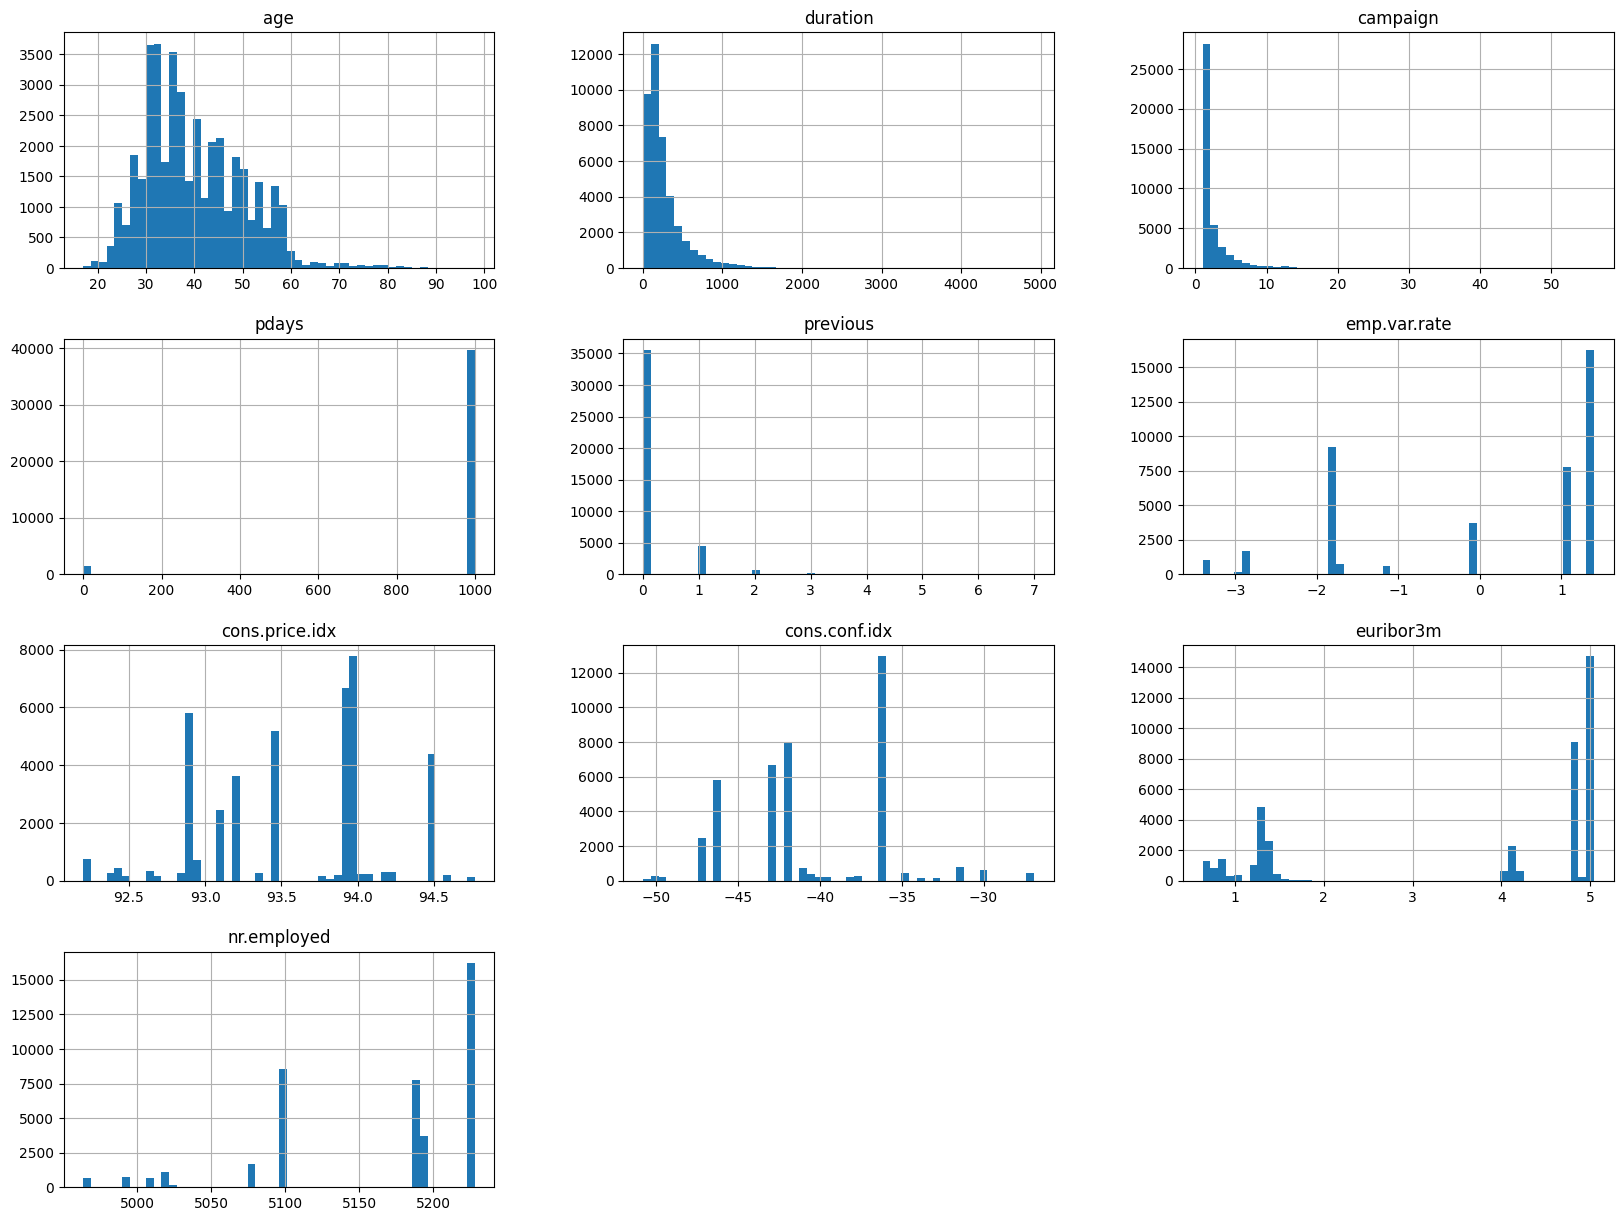

In [14]:
_ = df.hist(bins=50, figsize=(20,15))

We have some insights from here already which will help us decide how to move forward.

Some ideas:

- 'Category', 'Post Month', 'Post Weekday', 'Post Hour', and 'Paid' appear as numerical features, but they are categorical.
- Skewed distributions for most of the features -- standardisation or some other way of transforming the features might be needed (or at least attempted in our explorations).



Before we go any further, we should create our separate train and test splits. We will not look at the test set again until the end of the project.

In [15]:
# Create separate training and test sets. we'll use the training set for steps 3--6
train_set, test_set = train_test_split(df, test_size=0.2, random_state=23)
# by setting a random_state above, we make sure anytime we run this line we end up with the same train and test sets
print(len(train_set), len(test_set))

32950 8238


In [16]:
# Let's make a copy of the training set to ensure we don't mess things up
df = train_set.copy()

What we do from now on depends on the data we're working with. Some examples below.

Let's look only at some potential features

In [17]:
features = ["pdays", "previous", "emp.var.rate"]
df[features].head()

,pdays,previous,emp.var.rate
21196,999,0,1.4
8496,999,0,1.4
33264,999,0,-1.8
3031,999,0,1.1
25559,999,0,-0.1


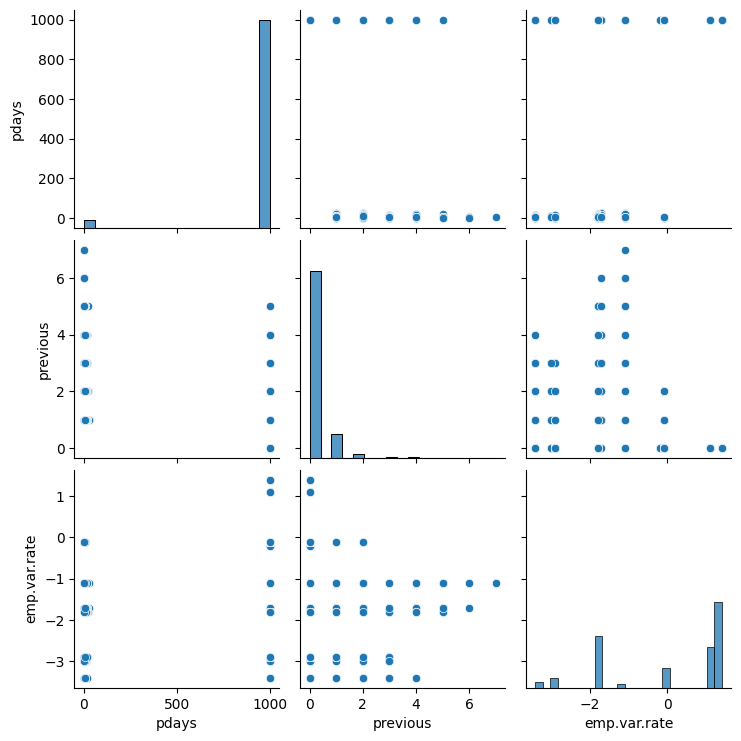

In [18]:
# Scatterplots
_ = sns.pairplot(df[features])
# An equivalent plot can be done with pandas:
#_ = pd.plotting.scatter_matrix(df[features], figsize=(12, 8))

In [19]:
# Correlations
num_features = ["previous", "emp.var.rate"]
correlations = df[num_features+['duration']].corr()  # this is a dataframe
# let's see how much each attribute correlates with the outcome 'duration'
correlations['duration'].sort_values(ascending=False)

duration        1.000000
previous        0.024542
emp.var.rate   -0.030611
Name: duration, dtype: float64

Note that correlations only tell us of a LINEAR relationship between two variables. Small correlations do not imply no information at all, only that if there is, it is not linear.

We now have some information about our data that we can use to model. Let's move on to step 4 "Prepare the data for ML", but note that this is an iterative process (insights -> prototype -> analyse -> insights -> ...)

At this stage we can also do feature ingeneering: create more features from the ones you have and check if the correlation with the outcome improves. If we use them in our model, we'll need them later on for our test set as well, but we'll see how to do this below.

### Prepare data for ML algorithms

Use functions were possible:

    - Reproducing on a new dataset is easier
    - Reusable on other projects
    - To transform the data for deployment
    - Can see which transformations work best

First, let's revert to a new clean training set, and separate features from labels (if applicable -- not in unsupervised learning)

In [20]:
df = train_set.copy()
# Most algorithms cannot work with missing values. Three main ways to deal with them:
# 1. Drop rows
# 2. Drop features with NaNs
# 3. Fill missing values
# As we have very few missing values, let's drop the rows
print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))
# Separate features from outcomes
y_df = df['duration'].copy()
X_df = df[features].copy()

Number of rows before dropping NaNs: 32950
Number of rows after dropping NaNs: 32950


In [21]:
# We previously observed that some of the features were categorical.
# Two main ways to deal with these: OrdinalEncoder() or OneHotEncoding()

# Let's use OneHotEncoding for the categories ('Category', 'Paid', 'Type')
# As we will later want to transform the test set, let's follow good practice and create a custom transformer for a sklearn pipeline

# This is an example of how it would be done. Since this is a very simple transformation, there's a better way of doing it
# using ColumnTransformer. We show it below

class OneHotEncoderCategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features):
        self.cat_features = cat_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.get_dummies(X, columns=self.cat_features)



In [27]:
cat_features = ["pdays", "previous"]

encoder = OneHotEncoderCategoricalFeatures(cat_features)
X_oho = encoder.transform(X_df)
X_oho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32950 entries, 21196 to 9256
Data columns (total 36 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   emp.var.rate  32950 non-null  float64
 1   pdays_0       32950 non-null  bool   
 2   pdays_1       32950 non-null  bool   
 3   pdays_2       32950 non-null  bool   
 4   pdays_3       32950 non-null  bool   
 5   pdays_4       32950 non-null  bool   
 6   pdays_5       32950 non-null  bool   
 7   pdays_6       32950 non-null  bool   
 8   pdays_7       32950 non-null  bool   
 9   pdays_8       32950 non-null  bool   
 10  pdays_9       32950 non-null  bool   
 11  pdays_10      32950 non-null  bool   
 12  pdays_11      32950 non-null  bool   
 13  pdays_12      32950 non-null  bool   
 14  pdays_13      32950 non-null  bool   
 15  pdays_14      32950 non-null  bool   
 16  pdays_15      32950 non-null  bool   
 17  pdays_16      32950 non-null  bool   
 18  pdays_17      32950 non-null

In [28]:
# Let's also look at standardising some of the numerical features
num_features = ['emp.var.rate']

# Use column transformer: numerical features will be standardised; categorical features will be transformed with OHO

# We can use a ColumnTransformer to transform only some types of columns in different ways
colTransformer = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
    ],
    remainder='passthrough'  # i.e., leave the rest of the columns untouched -- otherwise, they're dropped
    )

X_processed = colTransformer.fit_transform(X_df)
X_processed.shape

(32950, 36)

In [29]:
X_processed[0,:]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 36)>

## Regression

We can now train a regressor and then use the bootstrap to find an approximation of the bias and the variance

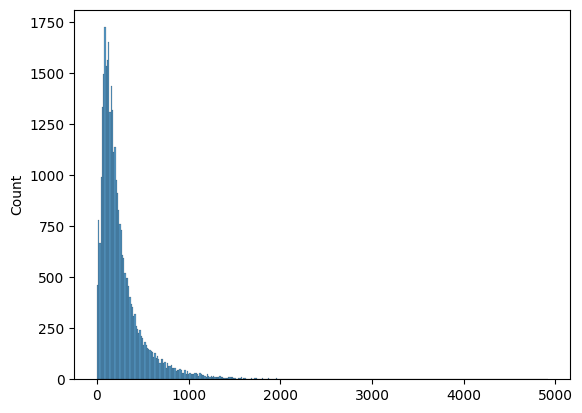

In [30]:
y = y_df.values
_ = sns.histplot(y, kde=False)

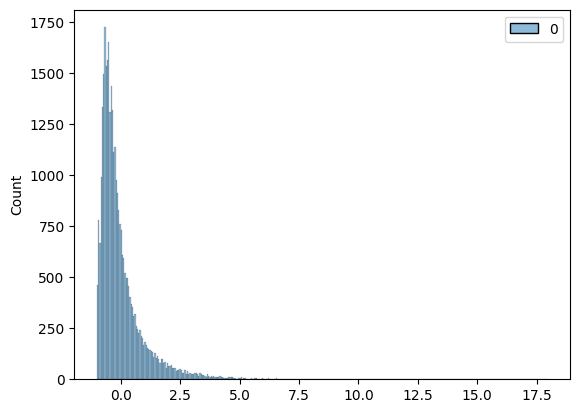

In [31]:
# Since the 'y' is skewed and the range is very large, we can also transform it
y_transformer = StandardScaler()  # we'll need this scaler for the test set later!
y = y_transformer.fit_transform(y.reshape(-1,1))
_ = sns.histplot(y, kde=False)

Let's try some models

In [32]:
clf = DecisionTreeRegressor()  # Decision tree
clf.fit(X_processed, y)
print("RMSE of the model = %1.4g" % np.sqrt(mse(y, clf.predict(X_processed))))

RMSE of the model = 0.9934


In [33]:
dummy_clf = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy_clf, X_processed, y.ravel(), cv=10, scoring = make_scorer(mse))

print("Dummy RMSE: %0.8f +/- %0.8f" % (np.sqrt(dummy_scores).mean(), np.sqrt(dummy_scores).std()))



Dummy RMSE: 0.99965467 +/- 0.02763677


c:\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[ 0 27 29 30 31 20  9 13  4  5  6 11  8  7 12 32 14 15 28  3 10  2  1 16
 18 33 17 19 23 34 21 22 24 25 26 35]
Feature ranking:
1. emp.var.rate (0.345133)
2. 999 (0.159463)
3. 1 (0.092552)
4. 2 (0.051462)
5. 3 (0.036092)
6. 19 (0.030822)
7. 8 (0.024058)
8. 12 (0.023725)
9. 3 (0.021246)
10. 4 (0.017521)
11. 5 (0.017351)
12. 10 (0.016805)
13. 7 (0.015458)
14. 6 (0.015359)
15. 11 (0.014368)
16. 4 (0.013643)
17. 13 (0.013531)
18. 14 (0.013197)
19. 0 (0.013138)
20. 2 (0.012697)
21. 9 (0.012628)
22. 1 (0.008920)
23. 0 (0.007371)
24. 15 (0.004622)
25. 17 (0.003812)
26. 5 (0.003285)
27. 16 (0.003055)
28. 18 (0.002318)
29. 22 (0.001722)
30. 6 (0.001213)
31. 20 (0.001078)
32. 21 (0.001005)
33. 25 (0.000576)
34. 26 (0.000567)
35. 27 (0.000170)
36. 7 (0.000033)


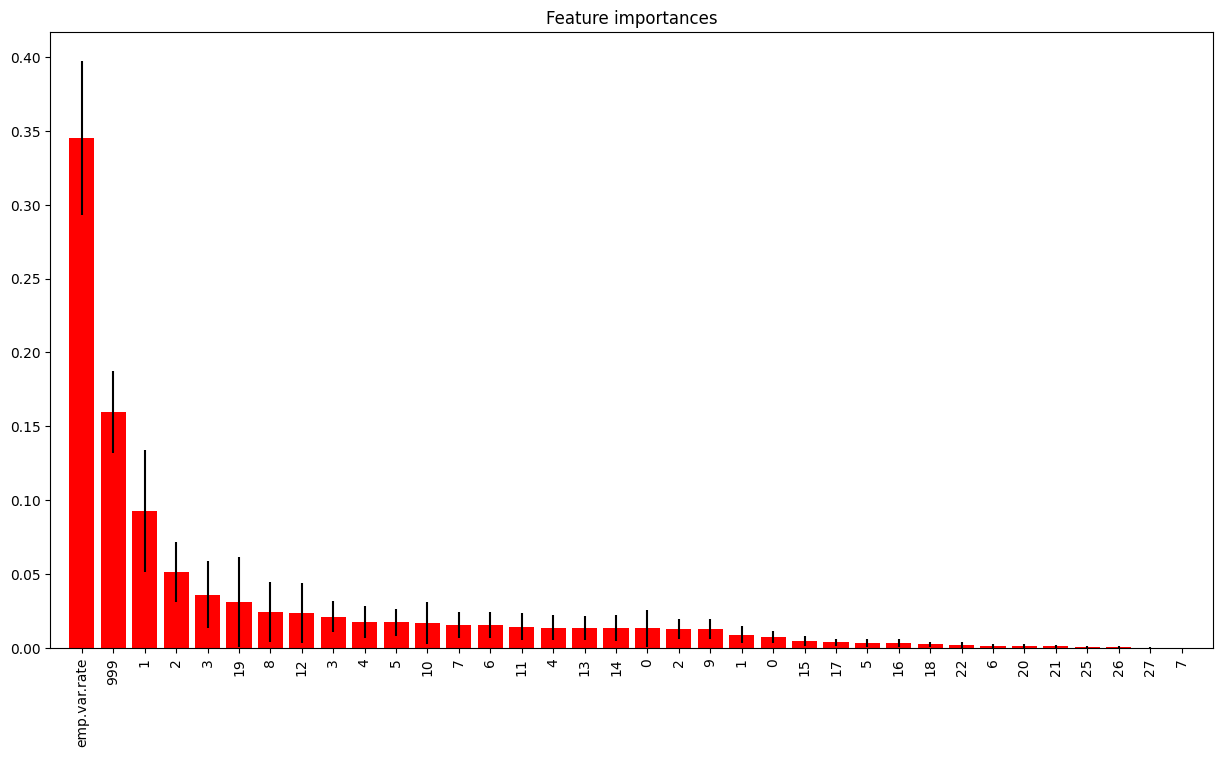

In [35]:
# Let's see the feature importances for our classifier

clf = RandomForestRegressor()
clf.fit(X_processed, y)


importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
# Let's get the attibute names:
extra_attribs = ['pdays', 'previous']  # the ones we didn't modify in the transformer
cat_encoder = colTransformer.named_transformers_['cat']
cat_oho_attributes = oho_categories = [item for sublist in cat_encoder.categories_ for item in sublist]
feat_names = num_features + cat_oho_attributes + extra_attribs

# Print the feature ranking
print("Feature ranking:")
for f in range(X_processed.shape[1]):
    print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X_processed.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_processed.shape[1]), np.array(feat_names)[indices], rotation=90)
plt.xlim([-1, X_processed.shape[1]])
plt.ylim([0, None])

fig.set_size_inches(15, 8)

## Classification

Let's divide the output of interest into bins, and see if we can do any better

In [26]:
outcomes_of_interest = ["Lifetime Post Consumers", "like"]
n_bins = 20

y_df = df[outcomes_of_interest].copy()
y_df["like"], bins = pd.qcut(y_df["like"], n_bins, retbins=True)

outcomesLabelEncoder = LabelEncoder()
y_df['like'] = outcomesLabelEncoder.fit_transform(y_df['like'])

y_df['id'] = range(1, len(df) + 1)

y_df.head()

,Lifetime Post Consumers,like,id
61,513,12,1
13,134,11,2
183,1956,17,3
38,5202,16,4
479,1078,7,5


In [27]:
X = X_processed  # Same we used for regression
y = y_df['like'].values.T

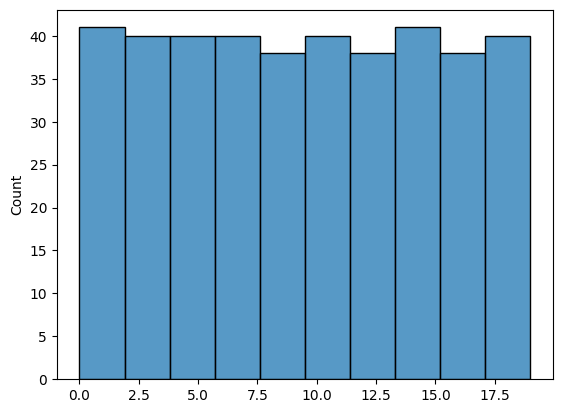

In [28]:
_ = sns.histplot(y, kde=False)  # our distribution of labels

In [30]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_processed, y)
print("Dummy ACC: %.2f" % acc(y, dummy_clf.predict(X_processed)))

Dummy ACC: 0.05


In [31]:
clf = ExtraTreesClassifier(n_estimators=1000, max_depth=4)
scores = cross_val_score(clf, X_processed, y, cv=10, scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.08 +/- 0.03


[ 1 10  0  8  9  4  5 11  6  3  2  7]
Feature ranking:
1. 1 (0.139770)
2. Post Weekday (0.135386)
3. Page total likes (0.110294)
4. Post Month (0.107165)
5. Post Hour (0.098217)
6. Link (0.096895)
7. Photo (0.064758)
8. Paid (0.063900)
9. Status (0.061250)
10. 3 (0.059699)
11. 2 (0.040582)
12. Video (0.022083)


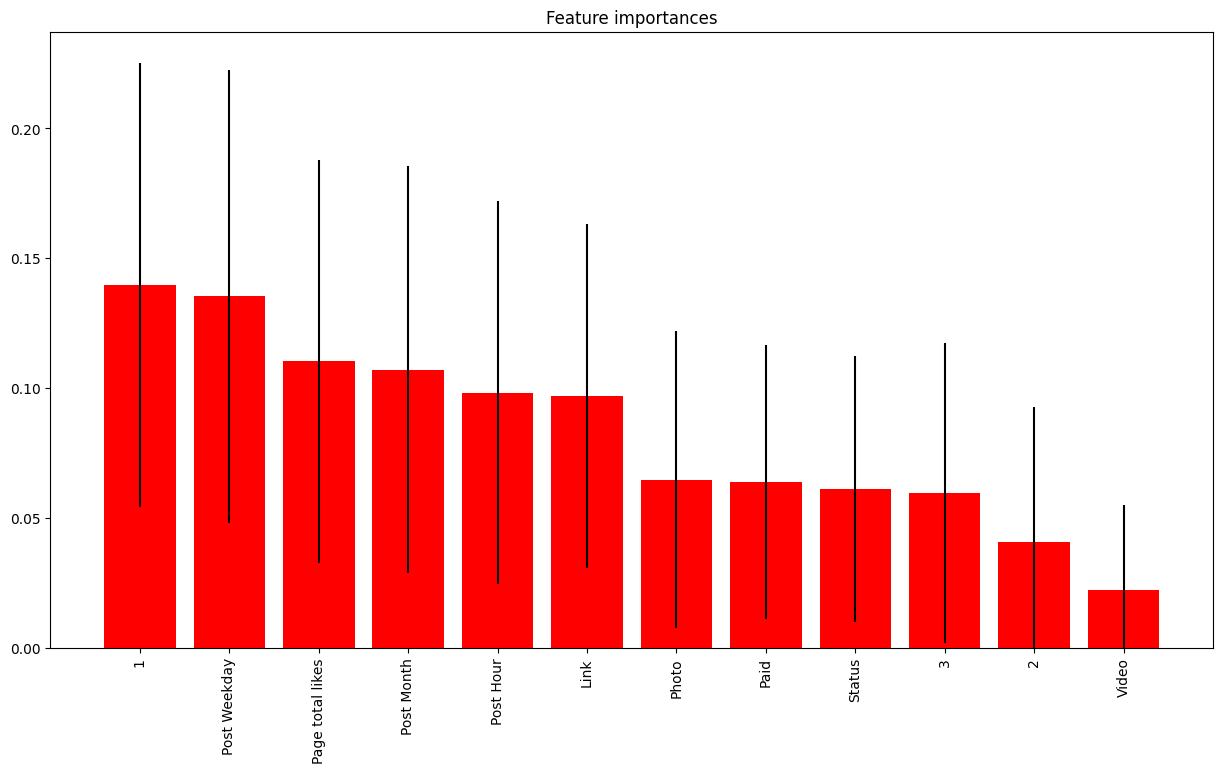

In [33]:
# Fit the model
clf.fit(X_processed, y)

# Let's see the feature importances for our classifier
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print(indices)
# Let's get the attibute names:
extra_attribs = ['Post Month', 'Post Hour', 'Post Weekday', 'Paid']  # the ones we didn't modify in the transformer
cat_encoder = colTransformer.named_transformers_['cat']
cat_oho_attributes = oho_categories = [item for sublist in cat_encoder.categories_ for item in sublist]
feat_names = num_features + cat_oho_attributes + extra_attribs

# Print the feature ranking
print("Feature ranking:")
for f in range(X_processed.shape[1]):
    print("%d. %s (%f)" % (f + 1, feat_names[indices[f]],  importances[indices[f]]))

# Plot the feature importances of the forest
fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(feat_names)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, None])

fig.set_size_inches(15, 8)


Now we could try dropping some of the less useful features, or check the errors made by our system. Let's check the confusion matrix.

In [34]:
# Get prediction on the test set
# Remember we need to do the same operations we did for the training test!
df_test = test_set.copy()
print('Size of test set: %d' % len(df_test))
# Drop rows with nans
df_test = df_test.dropna()
print("Number of rows after dropping NaNs: %d" % len(df_test))

Size of test set: 100
Number of rows after dropping NaNs: 99


In [35]:
# Separate features from outcomes
y_test_df = df_test[outcomes_of_interest].copy()
X_test_df = df_test[features].copy()
# Transform features
X_test = colTransformer.transform(X_test_df)
assert X_test.shape[1] == X_processed.shape[1]  # same number of features

In [36]:
# Make y into categories
y_test_df['like'] = pd.cut(y_test_df['like'], bins=bins, include_lowest=True)  # the bins previously returned by pd.qcut()
y_test_df['like'] = outcomesLabelEncoder.transform(y_test_df['like'])
y_test = y_test_df.values.T[1]  # lifetime post consumers

In [37]:
# Predict
test_predictions = clf.predict(X_test)
# What's the accuracy on the test set?
acc(y_test, test_predictions)

0.09090909090909091

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        t = "(%.2f)"%(cm[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Normalized confusion matrix


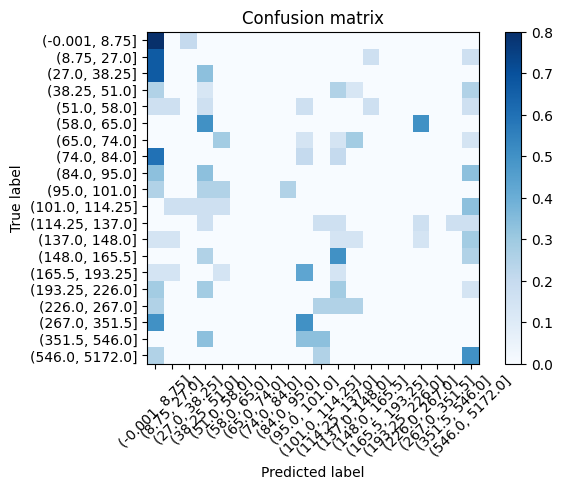

In [39]:
c = confusion_matrix(y_test, test_predictions)
plot_confusion_matrix(c, outcomesLabelEncoder.classes_)

A good classifier would have high values (i.e., dark blue) on the main diagonal, and low (i.e., light blue) values elsewhere. In this case, we are not observing that! The accuracy was very low (8%, which is just marginally better than random), so the fact that the results are so bad as seen on the confusion matrix makes sense.